# Feature Engineering

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np
from datetime import datetime, timedelta
colors = sns.color_palette('pastel')

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the base path and data path
base_path = '/content/drive/Shared drives/Deloitte'
data_path = base_path + '/Cleaned Data'

#Upload first dataset: customer_info_cleaned

feature_data = pd.read_csv(data_path + '/eda_cleaned.csv')

feature_data.head(5)

output_dir = '/content/drive/Shared drives/Deloitte/Cleaned Data'

Mounted at /content/drive


In [ ]:
feature_data.columns

Index(['sales_representative_id', 'id', 'latitude', 'longitude',
       'sales_representative_latitude', 'sales_representative_longitude',
       'distance', 'city', 'store_size', 'free_wifi', 'parking',
       'date_opening', 'store_size_category', 'opening_hour', 'closing_hour',
       'customer_category', 'distance_rep_cust_km', 'rating',
       'number_of_reviews', 'sales_amount', 'number_of_employees',
       'population', 'young_population', 'gdp_per_capita', 'unemployment_rate',
       'days_active', 'open_duration_hours', 'young_population_rate',
       'opening_bin', 'closing_bin', 'time_period'],
      dtype='object')

In [ ]:
#drop variables that are not needed for the feature engineering
feature_data.drop(['id', 'sales_representative_id', 'latitude', 'longitude', 'sales_representative_latitude', 'sales_representative_longitude'], axis=1, inplace=True)

We start by dropping variables that are converted into a new column or not relevant for feature engineering:
- Closing hour and opening hour are converted into open_duration_hours so can be deleted
- Closing bin and opening bin were used to create the variable 'time_period'
- Days_active and Opening duration hours were deleted because they were manipulated variables that we used for EDA

In [ ]:
feature_data.drop(['opening_bin', 'closing_bin', 'opening_hour', 'closing_hour','days_active', 'open_duration_hours'], axis=1, inplace=True)

In [ ]:
feature_data.dtypes

distance                 float64
city                      object
store_size               float64
free_wifi                  int64
parking                    int64
date_opening              object
store_size_category        int64
customer_category         object
distance_rep_cust_km     float64
rating                   float64
number_of_reviews        float64
sales_amount             float64
number_of_employees      float64
population                 int64
young_population           int64
gdp_per_capita             int64
unemployment_rate        float64
young_population_rate    float64
time_period               object
dtype: object

In [ ]:
feature_data["time_period"].unique()

array(['Evening to Morning', 'Afternoon to Late Night',
       'Morning to Evening', 'Late Night to Late Night',
       'Late Night to Afternoon'], dtype=object)

In [ ]:
feature_data["city"].unique()

array(['A Coruña', 'Bilbao', 'Alicante', 'Madrid', 'Caceres', 'Burgos',
       'Sevilla', 'Barcelona', 'Valencia', 'Zaragoza', 'Guadalajara',
       'Valladolid', 'Pamplona', 'Murcia', 'Palencia'], dtype=object)

In [ ]:
#change the date_opening variable for datetime
feature_data['date_opening'] = pd.to_datetime(feature_data['date_opening'], format='%Y-%m-%d')


In [ ]:
#check for extreme outliers as they can impact correlation
numerical_features = feature_data.select_dtypes(include=[np.number, 'datetime']).columns.tolist()
numerical_features

['distance',
 'store_size',
 'free_wifi',
 'parking',
 'date_opening',
 'store_size_category',
 'distance_rep_cust_km',
 'rating',
 'number_of_reviews',
 'sales_amount',
 'number_of_employees',
 'population',
 'young_population',
 'gdp_per_capita',
 'unemployment_rate',
 'young_population_rate']

In [ ]:
for column in feature_data.columns:
    fig = px.box(feature_data, y=column, title=f'Box Plot for {column}')
    fig.show()

In [ ]:
feature_data.columns

Index(['distance', 'city', 'store_size', 'free_wifi', 'parking',
       'date_opening', 'store_size_category', 'customer_category',
       'distance_rep_cust_km', 'rating', 'number_of_reviews', 'sales_amount',
       'number_of_employees', 'population', 'young_population',
       'gdp_per_capita', 'unemployment_rate', 'young_population_rate',
       'time_period'],
      dtype='object')

In [ ]:
#Delete the extreme outliers based on IQR

features_outliers = ['distance', 'store_size', 'distance_rep_cust_km', 'rating',
                     'number_of_reviews', 'sales_amount', 'number_of_employees',
                     'population', 'young_population', 'gdp_per_capita',
                     'unemployment_rate', 'young_population_rate']

# Function to remove outliers using IQR
def remove_outliers_iqr(feature_data, features):
    for feature in features:
        Q1 = feature_data[feature].quantile(0.25)
        Q3 = feature_data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        feature_data = feature_data[(feature_data[feature] >= lower_bound) & (feature_data[feature] <= upper_bound)]
    return feature_data

# Remove outliers
feature_data = remove_outliers_iqr(feature_data, features_outliers)


In [ ]:
for column in feature_data.columns:
    fig = px.box(feature_data, y=column, title=f'Box Plot for {column}')
    fig.show()

In [ ]:
#Check again the Box plots
for column in feature_data.columns:
    fig = px.box(feature_data, y=column, title=f'Box Plot for {column}')
    fig.show()

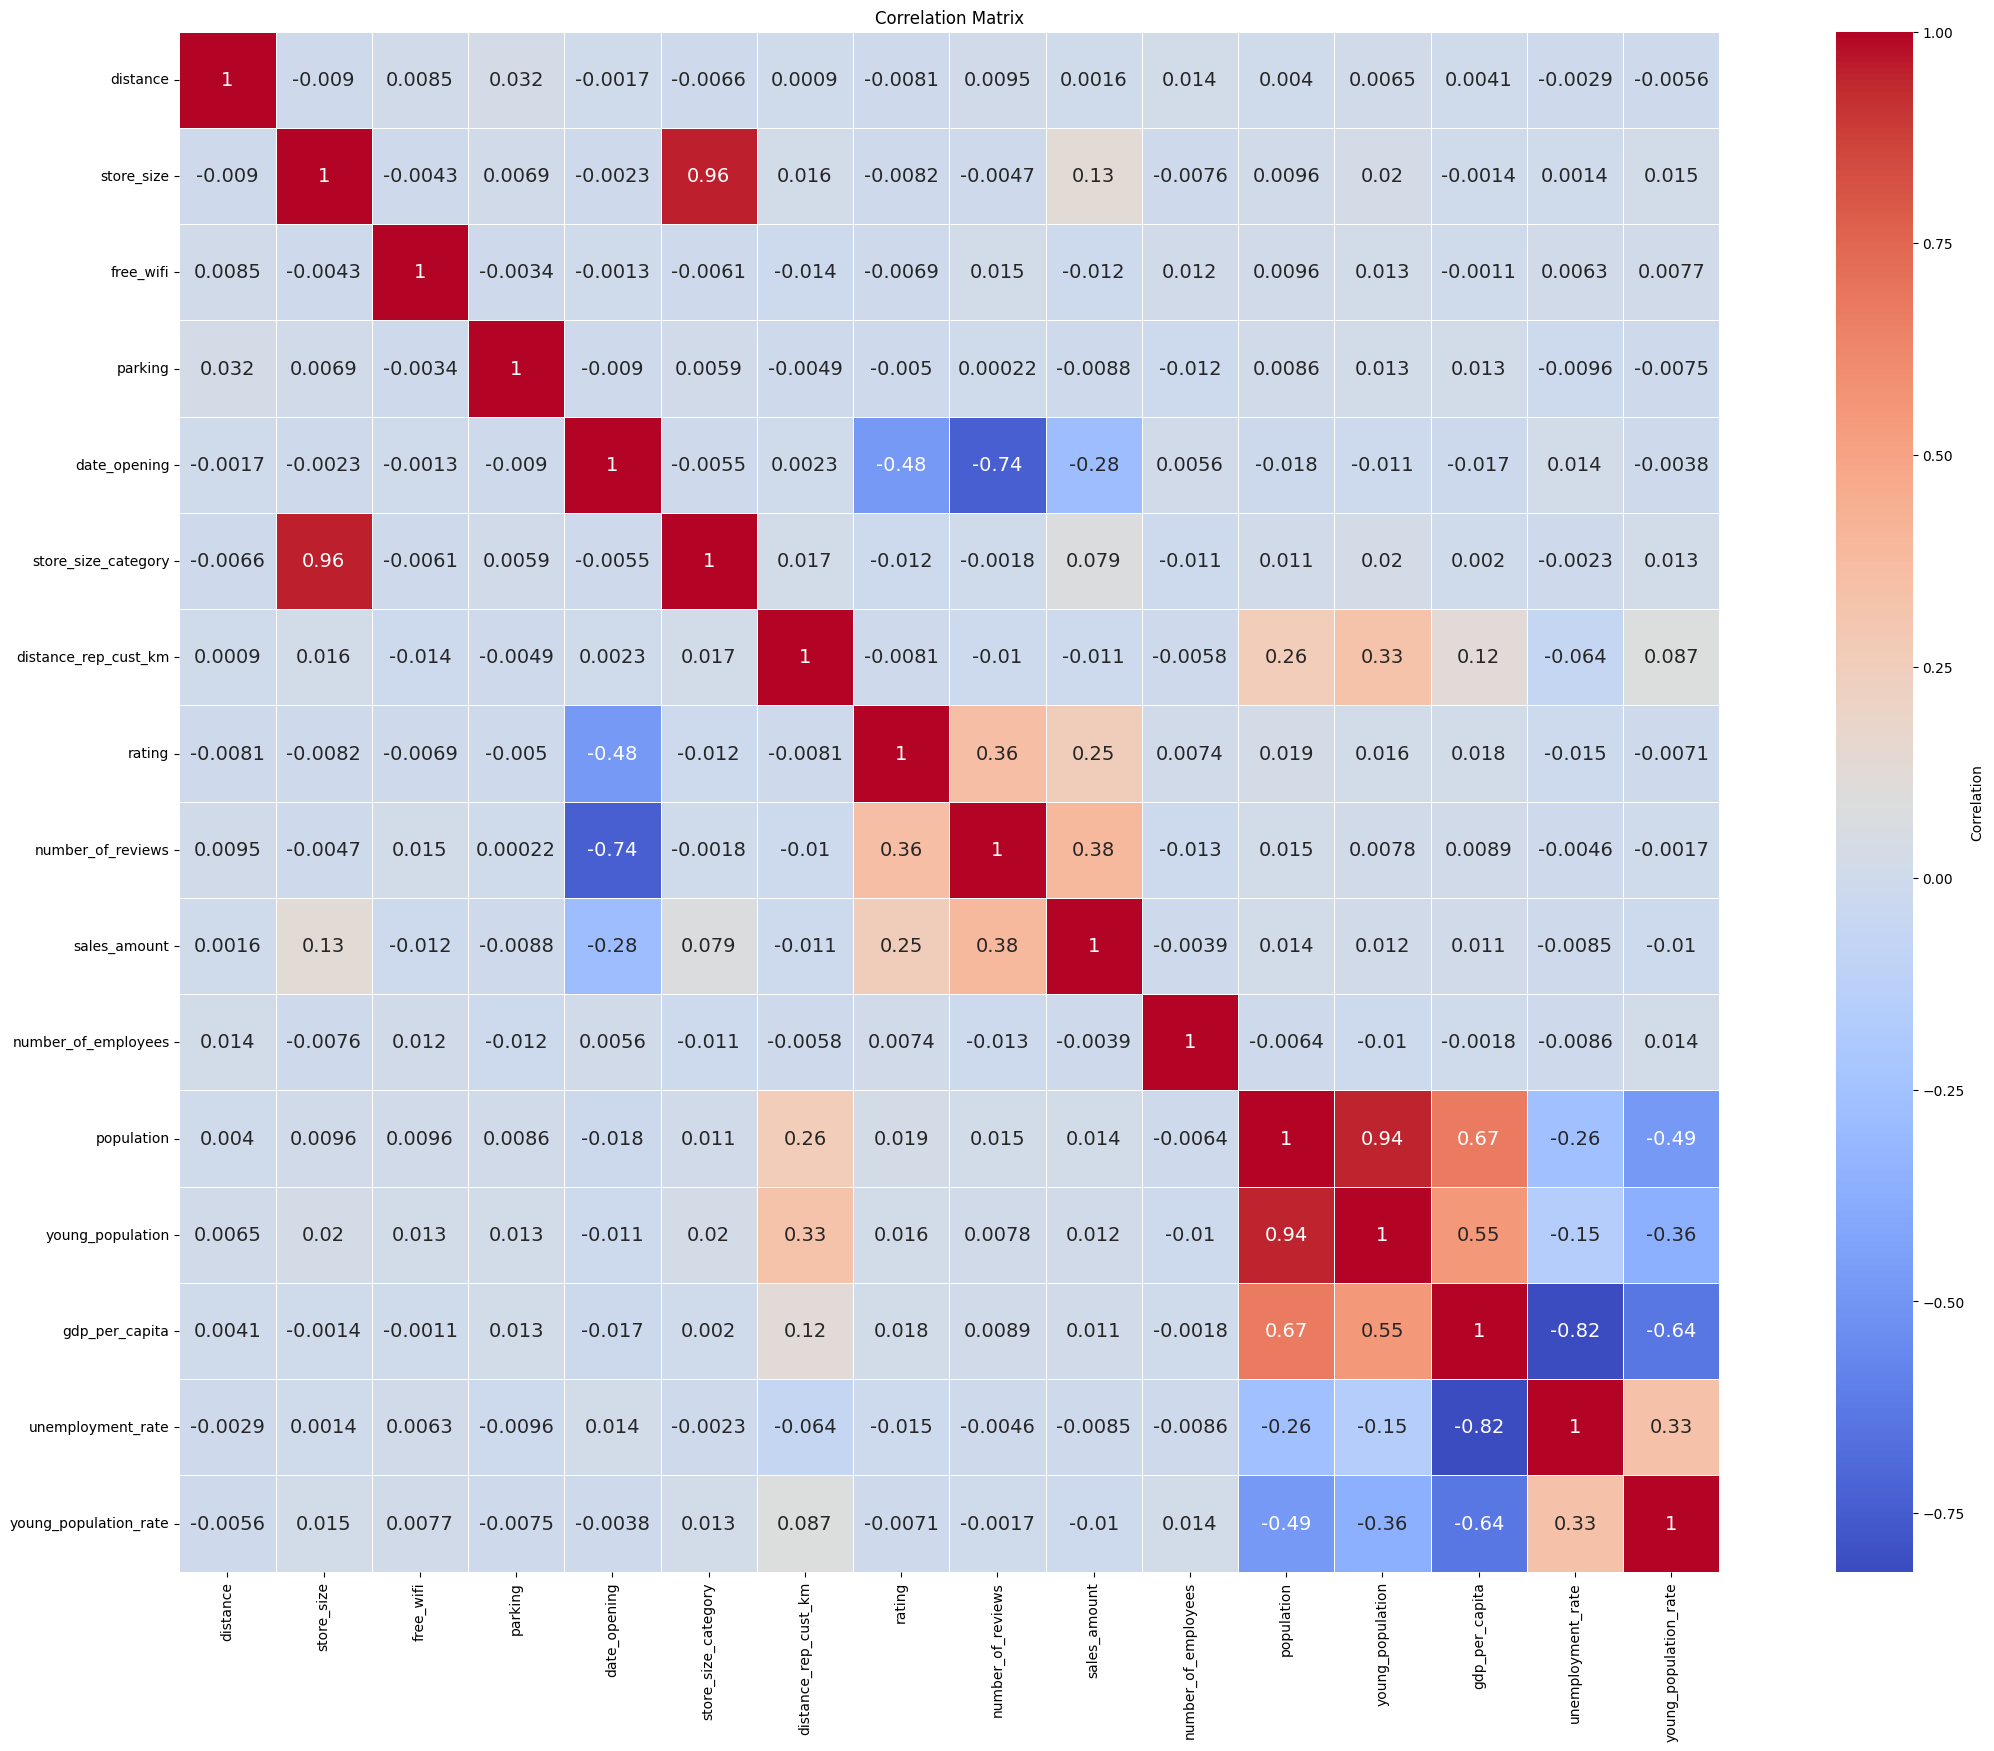

In [ ]:
plt.figure(figsize=(30, 20))
corr_matrix = feature_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 14},
            cbar_kws={"label": "Correlation"}, square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#drop variables that don't have any correlations with the target variable or another

feature_data.drop(['distance_rep_cust_km', 'distance','free_wifi', 'parking','number_of_employees'], axis=1, inplace=True)


### New Features

#### New Numerical Features

In [ ]:
#Create a new column in the DataFrame to store the year extracted from the date_opening column.

def encode_dates(feature_data, date_column):
    feature_data[date_column] = pd.to_datetime(feature_data[date_column])

    feature_data[date_column + '_year'] = feature_data[date_column].dt.year
    feature_data[date_column + '_month'] = feature_data[date_column].dt.month
    feature_data[date_column + '_day'] = feature_data[date_column].dt.day


    return feature_data

feature_data = encode_dates(feature_data, 'date_opening')


In [ ]:
print(feature_data.columns)

Index(['city', 'store_size', 'date_opening', 'store_size_category',
       'customer_category', 'rating', 'number_of_reviews', 'sales_amount',
       'population', 'young_population', 'gdp_per_capita', 'unemployment_rate',
       'young_population_rate', 'time_period', 'date_opening_year',
       'date_opening_month', 'date_opening_day'],
      dtype='object')


In [ ]:
#We deleted date_opening becuase we are going to use date_opening_year for our analysis
feature_data.drop(['date_opening'], axis=1, inplace=True)

### Correlation Matrix

In [ ]:
numerical_features = feature_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features

['store_size',
 'store_size_category',
 'rating',
 'number_of_reviews',
 'sales_amount',
 'population',
 'young_population',
 'gdp_per_capita',
 'unemployment_rate',
 'young_population_rate',
 'date_opening_year',
 'date_opening_month',
 'date_opening_day']

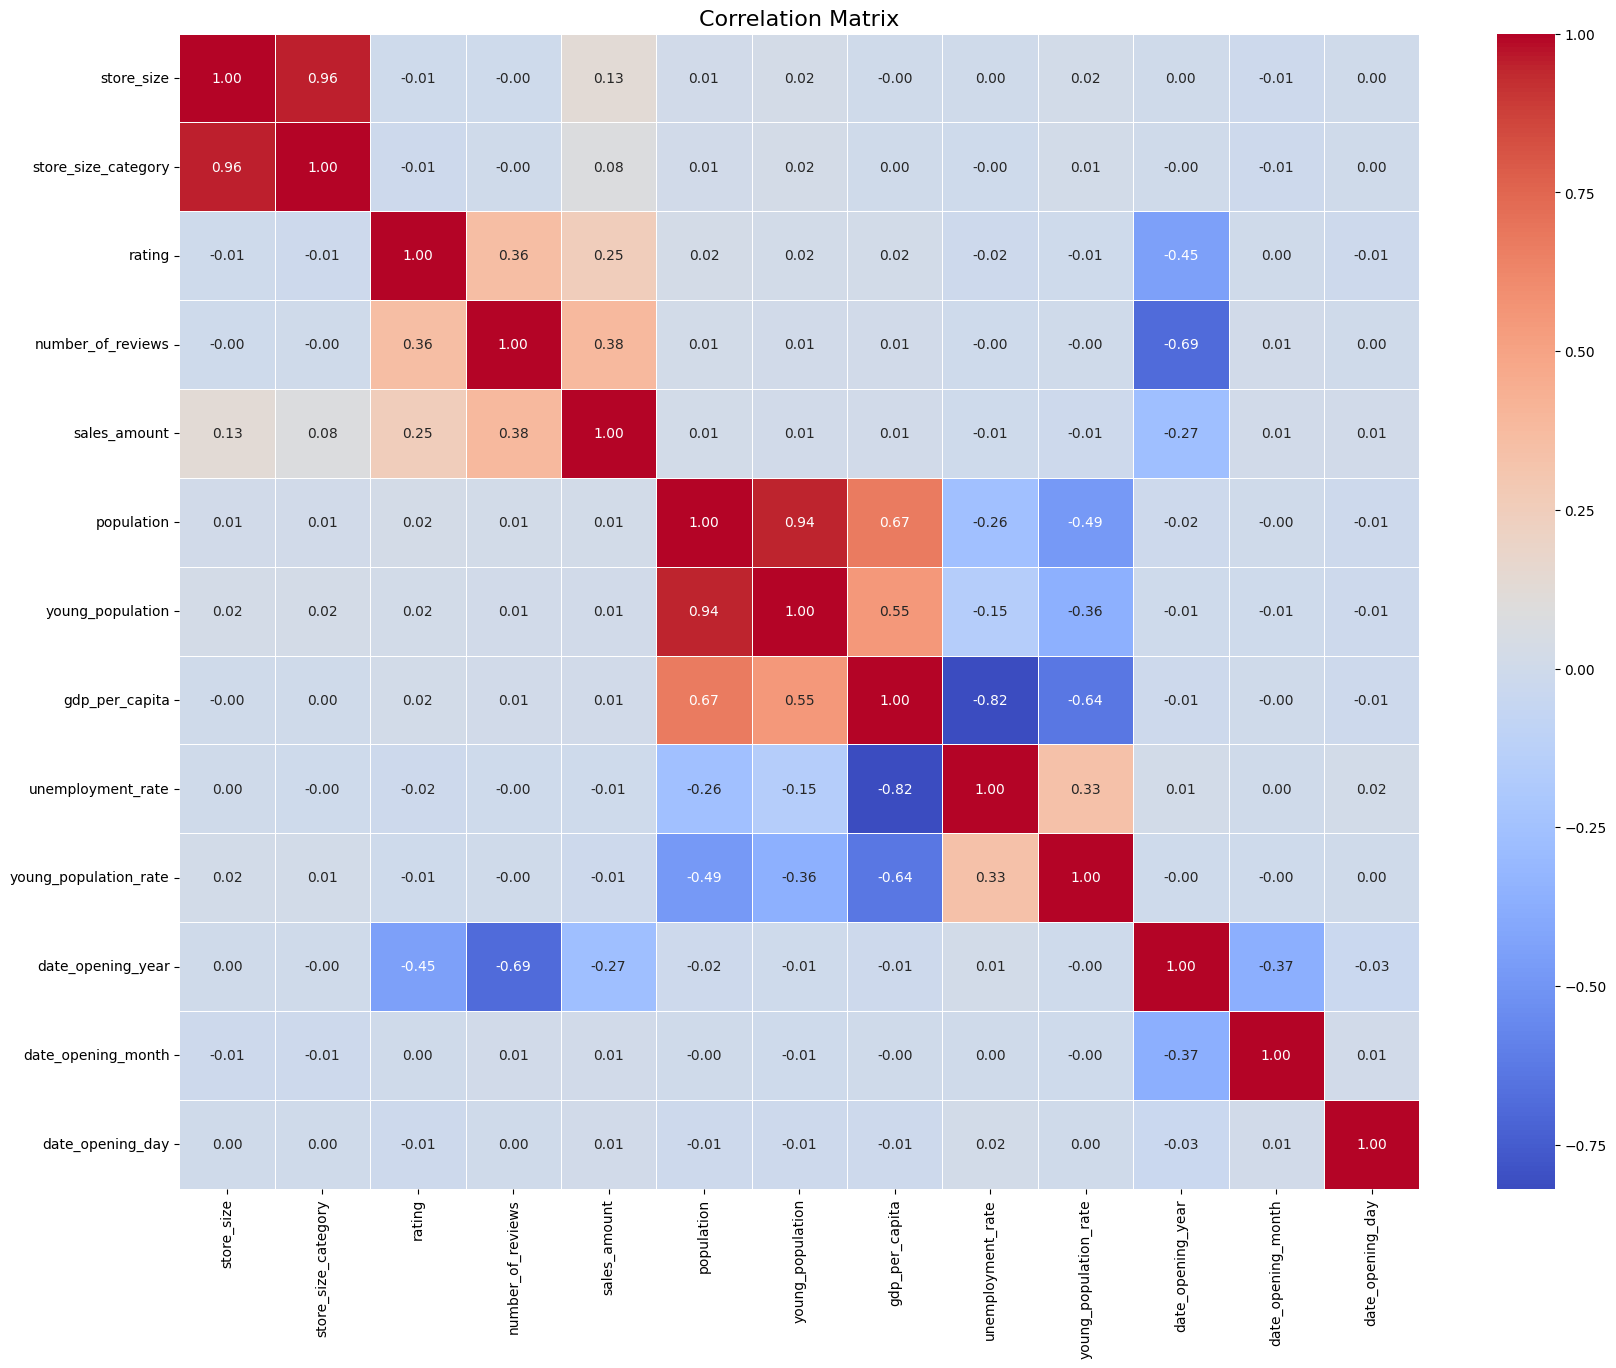

In [ ]:
# Heatmap to show correlation between explanatory variables
plt.figure(figsize=(20, 15))
corr = feature_data[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Columns to be deleted
- Simplifying the model by removing less important variables can make the model more interpretable and easier to maintain.

In [ ]:
#socio factors are supposedly not accurate so we delete them as they also don't have any impact on sales
#Sociodemographics factors need to be analyzed further as they are currently assumed to not be 'correct'
feature_data = feature_data.drop(columns=['population', 'unemployment_rate', 'gdp_per_capita', 'young_population_rate', 'young_population'])


In [ ]:
#store size and store_size_category are both the same content and therefore highly correlated, however store_size has a higher correlation on sales amount so we keep this variable
feature_data = feature_data.drop(columns=['store_size_category'])

In [ ]:
#Drop the date_opening 'month'and 'day' don't show any correlation with sales_amount
feature_data = feature_data.drop(columns=['date_opening_month','date_opening_day'])

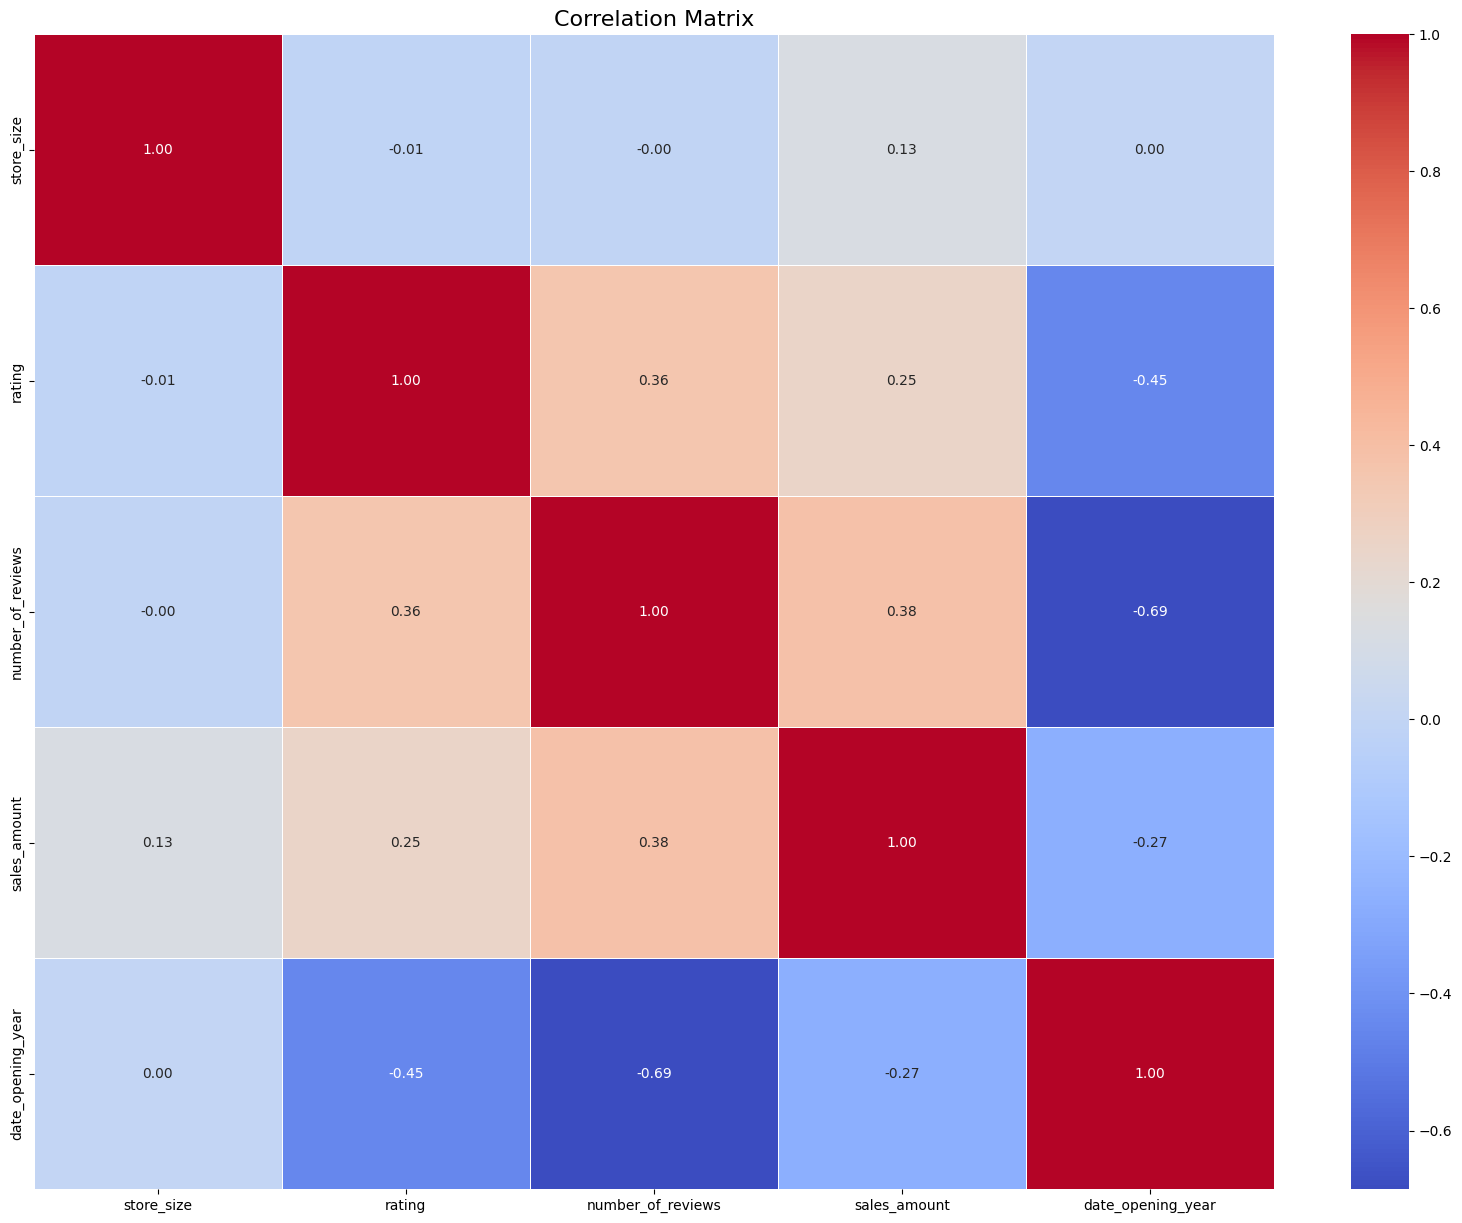

In [ ]:
#Heatmap to show correlation between explanatory variables
numerical_features = feature_data.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(20, 15))
corr = feature_data[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
#To check multicollinearity we used Variance Inflation Factor to see if any of our variables has multicollinearity
X = feature_data[numerical_features]
X = sm.add_constant(X)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             Feature           VIF
0              const  1.354587e+07
1         store_size  1.021403e+00
2             rating  1.285106e+00
3  number_of_reviews  2.064462e+00
4       sales_amount  1.220495e+00
5  date_opening_year  2.074620e+00


Since the values are all below 5, there is no need to handle multicollinearity between numerical variables.

## Handling Categorical Varibales

In [ ]:
#Select categorical variables
categorical_columns = feature_data.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['city', 'customer_category', 'time_period'], dtype='object')


In [ ]:
feature_data["time_period"].unique()

array(['Evening to Morning', 'Afternoon to Late Night',
       'Morning to Evening', 'Late Night to Late Night',
       'Late Night to Afternoon'], dtype=object)

We used one-hot encoding for nominal variables where there is no ordinal relationship between categories, which is the case of 'city', 'customer_category' and 'time_period', variables.

In [ ]:
feature_data = pd.get_dummies(feature_data, columns=['city','customer_category','time_period'], drop_first=True)

In [ ]:
feature_data.dtypes

store_size                              float64
rating                                  float64
number_of_reviews                       float64
sales_amount                            float64
date_opening_year                         int32
city_Alicante                              bool
city_Barcelona                             bool
city_Bilbao                                bool
city_Burgos                                bool
city_Caceres                               bool
city_Madrid                                bool
city_Sevilla                               bool
city_Valencia                              bool
city_Valladolid                            bool
city_Zaragoza                              bool
customer_category_Hotel                    bool
customer_category_Restaurant               bool
time_period_Evening to Morning             bool
time_period_Late Night to Afternoon        bool
time_period_Late Night to Late Night       bool
time_period_Morning to Evening          

In [ ]:
#Convert boolean columns to float
for col in feature_data.select_dtypes(include=['bool']).columns:
    feature_data[col] = feature_data[col].astype(float)


In [ ]:
# Ensure all columns are numeric
feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

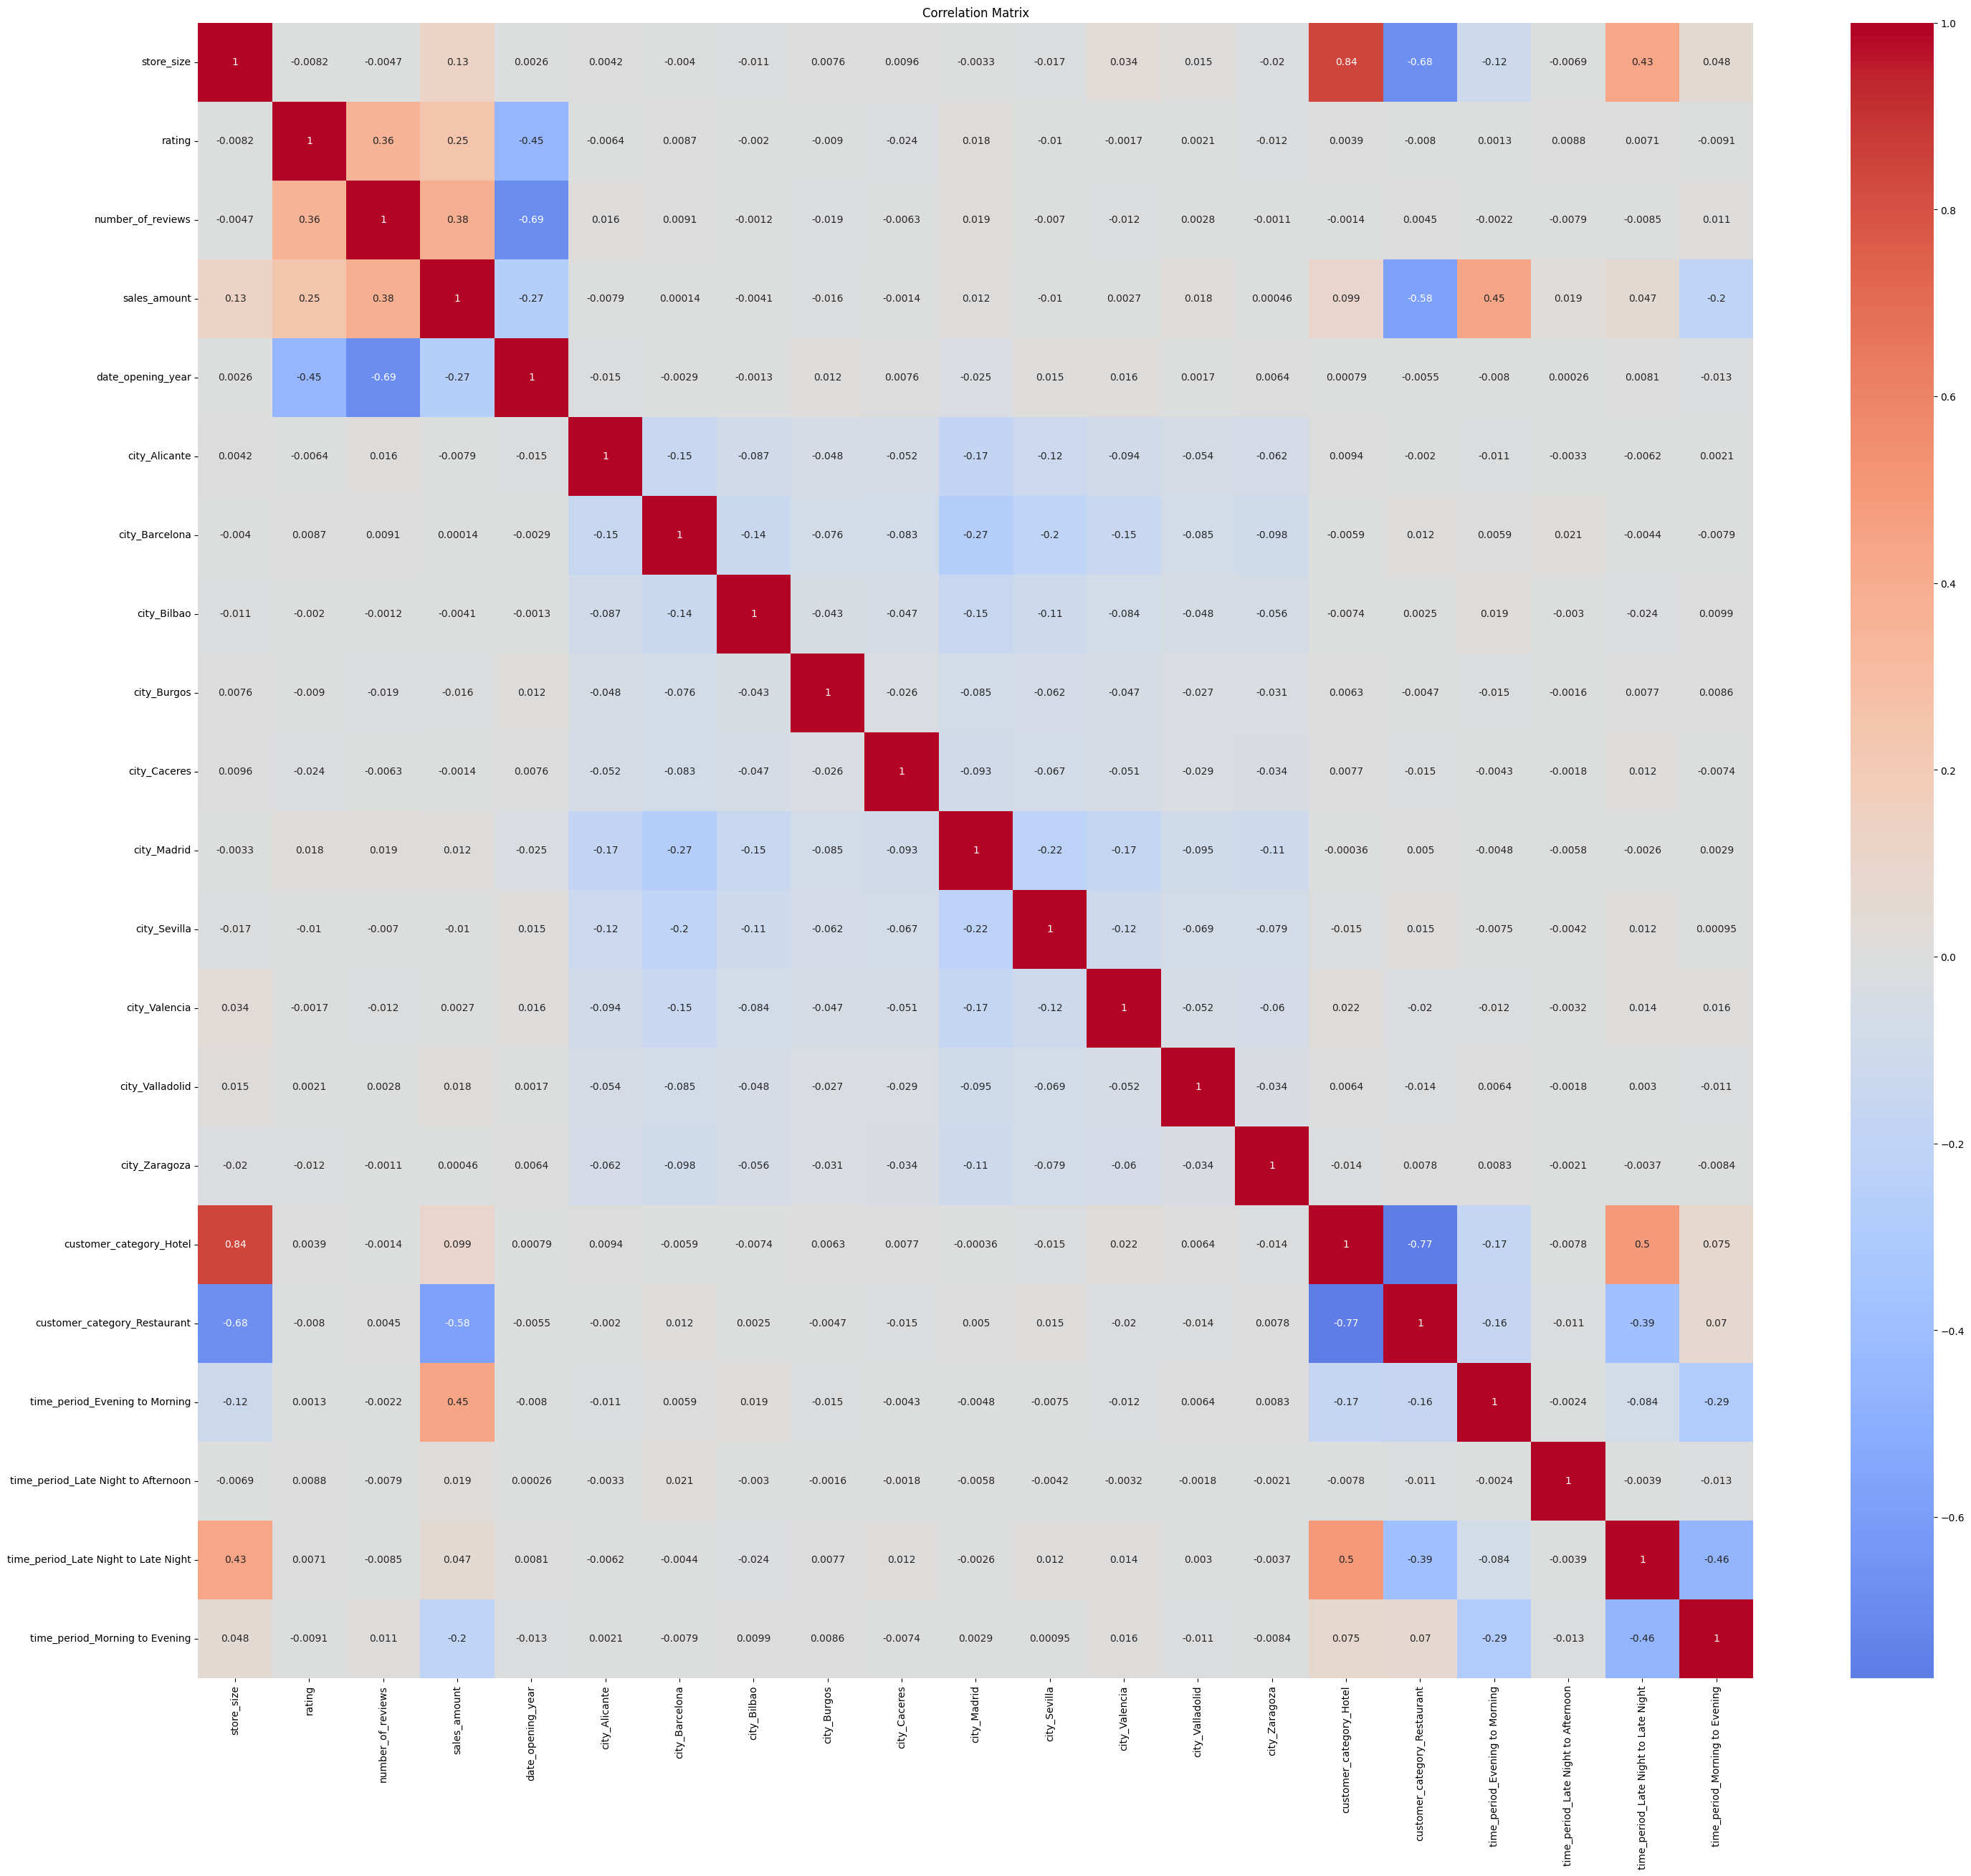

In [ ]:
corr_matrix = feature_data.corr()
plt.figure(figsize=(35, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#Since cities don't have any correlation with the target vairable we decided to drop them
feature_data = feature_data.drop(columns=['city_Madrid', 'city_Alicante','city_Barcelona', 'city_Bilbao' , 'city_Burgos', 'city_Caceres', 'city_Sevilla', 'city_Valencia', 'city_Valladolid', 'city_Zaragoza'])

In [ ]:
numerical_features = feature_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features

['store_size',
 'rating',
 'number_of_reviews',
 'sales_amount',
 'date_opening_year',
 'customer_category_Hotel',
 'customer_category_Restaurant',
 'time_period_Evening to Morning',
 'time_period_Late Night to Afternoon',
 'time_period_Late Night to Late Night',
 'time_period_Morning to Evening']

### Checking the correaltion between all the variables

In [ ]:
feature_data.drop(['store_size'], axis=1, inplace=True)

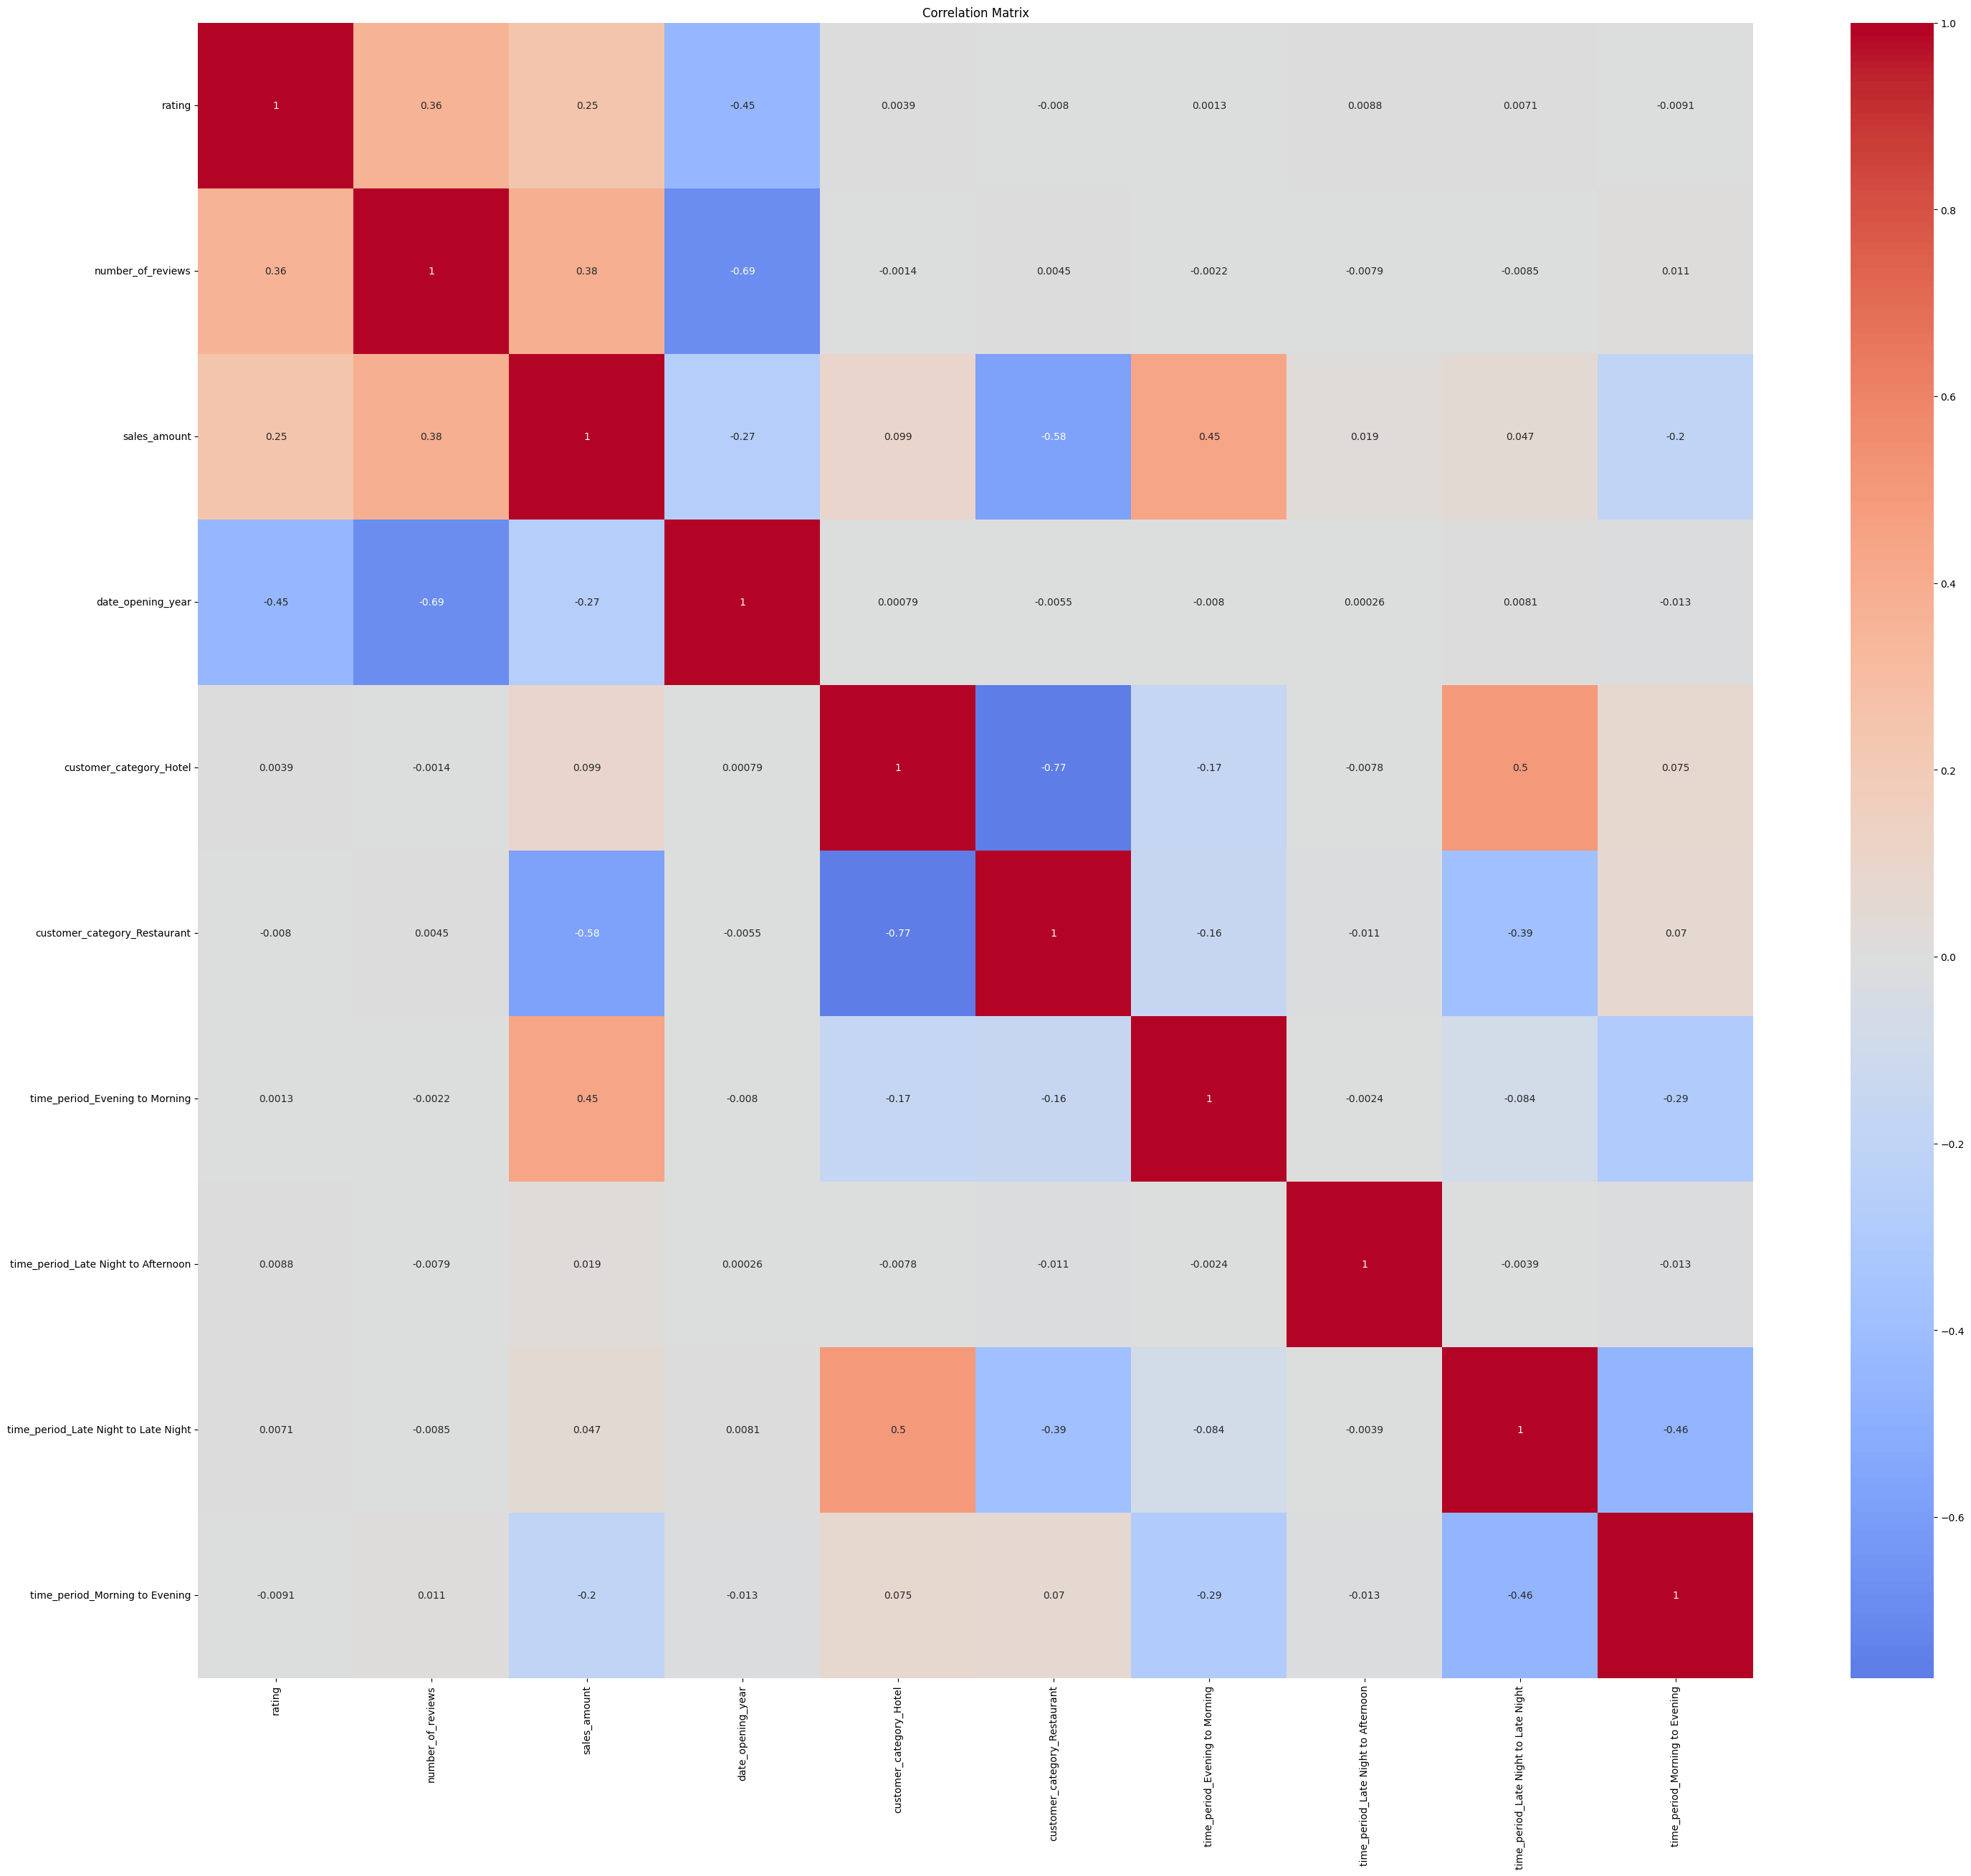

In [ ]:
corr_matrix = feature_data.corr()
plt.figure(figsize=(35, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
numerical_features = feature_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features


['rating',
 'number_of_reviews',
 'sales_amount',
 'date_opening_year',
 'customer_category_Hotel',
 'customer_category_Restaurant',
 'time_period_Evening to Morning',
 'time_period_Late Night to Afternoon',
 'time_period_Late Night to Late Night',
 'time_period_Morning to Evening']

In [ ]:
#To check multicolinearity we used Variance Inflation Factor to see if any of our variables has multicolinearity
X = feature_data[numerical_features]
X = sm.add_constant(X)

#Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                                 Feature           VIF
0                                  const  1.359206e+07
1                                 rating  1.350308e+00
2                      number_of_reviews  2.638291e+00
3                           sales_amount  5.358299e+00
4                      date_opening_year  2.082558e+00
5                customer_category_Hotel  6.881070e+00
6           customer_category_Restaurant  1.019770e+01
7         time_period_Evening to Morning  1.496546e+00
8    time_period_Late Night to Afternoon  1.001583e+00
9   time_period_Late Night to Late Night  2.093408e+00
10        time_period_Morning to Evening  1.734361e+00


Since the values are all below 5, there is no need to handle multicollinearity.

In [ ]:
numerical_features = feature_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features


['rating',
 'number_of_reviews',
 'sales_amount',
 'date_opening_year',
 'customer_category_Hotel',
 'customer_category_Restaurant',
 'time_period_Evening to Morning',
 'time_period_Late Night to Afternoon',
 'time_period_Late Night to Late Night',
 'time_period_Morning to Evening']

### Save for Feature Engineering

In [ ]:
feature_data.to_csv(output_dir + "/features_cleaned.csv", index=False)